# NLP Analysis of Uncle Tom's Cabin

In [1]:
import numpy as np
import pandas as pd

import spacy
from textblob import TextBlob
from collections import defaultdict
from collections import Counter
import networkx as nx
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set font as Arial
plt.rcParams['font.family'] = 'Arial'
%matplotlib inline

In [2]:
def load_text(file_path: str) -> str:
    """
    Loads the text from a file and returns it as a string.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

# Example usage:
text = load_text("data/uncle_toms_cabin.txt")

# Truncate at 1000000 characters
text_truncated = text[:1000000]

In [3]:
# nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_lg")

def get_doc(text: str):
    """
    Process text with SpaCy for further analysis.
    """
    return nlp(text)

# Example usage:
doc = get_doc(text_truncated)

In [4]:
# Print document statistics
print(f"Document statistics:")
print(f"  - Number of sentences: {len(list(doc.sents))}")
print(f"  - Number of tokens: {len(doc)}")
print(f"  - Number of unique tokens: {len(set(doc))}")
print(f"  - Number of named entities: {len([ent for ent in doc.ents if ent.label_ == 'PERSON'])}")


Document statistics:
  - Number of sentences: 10925
  - Number of tokens: 246762
  - Number of unique tokens: 246762
  - Number of named entities: 4369


In [5]:
character_aliases = {
    # 1. Uncle Tom
    "Uncle Tom": [
        "Uncle Tom",
        "Tom",
        "UNCLE TOM",    # All-caps variant
        "Uncle Tom’s"   # Possessive form
    ],

    # 2. Aunt Chloe
    "Aunt Chloe": [
        "Aunt Chloe",
        "Chloe",
        # Variants that appear with punctuation/line breaks:
        "Aunt\nChloe", 
        "Aunt Chloe,—“I"
    ],

    # 3. Eliza Harris
    "Eliza Harris": [
        "Eliza Harris",
        "Eliza",
        "Mrs. Harris",
        # Common dialect/spelling variants:
        "Liza",
        "Lizzy",
        "Lizy",
        # The text sometimes shows her name with punctuation/line breaks:
        "Eliza\n",             
        "Eliza trembled",      
        "Eliza glided\nforward",
        "Eliza tremulously",  
        # You may want to strip punctuation/line breaks depending on your approach
    ],

    # 4. George Harris
    "George Harris": [
        "George Harris",
        "George",
        "Mr. Harris",
        # Occasionally split across lines in the text:
        "George\nHarris"
    ],

    # 5. Evangeline "Eva" St. Clare
    "Evangeline \"Eva\" St. Clare": [
        "Eva",
        "Little Eva",
        "Miss Eva",
        "Evangeline St. Clare",
        "Evangeline \"Eva\" St. Clare",
        "Eva."  # sometimes appears with punctuation
    ],

    # 6. Augustine St. Clare
    "Augustine St. Clare": [
        "Augustine",
        "Mr. St. Clare",
        "Master St. Clare",
        "Augustine St. Clare",
        # Variants/punctuation from text:
        "St. Clare",
        "Augustine St.\nClare",
        "Augustine St."
    ],

    # 7. Marie St. Clare
    "Marie St. Clare": [
        "Marie",
        "Mrs. St. Clare",
        "Marie St. Clare",
        "Miss\nMarie",       # appears with a line break
        "Marie St. Clare’s"  # possessive form
    ],

    # 8. Miss Ophelia (Ophelia St. Clare)
    "Miss Ophelia": [
        "Miss Ophelia",
        "Ophelia",
        "Cousin Ophelia",
        # Sometimes referred to with last name or line breaks:
        "Ophelia St. Clare",
        "Miss\nOphelia",
        # Topsy’s nickname for her:
        "Feely",
        "Feeley",
        "Phelia"
    ],

    # 9. Topsy
    "Topsy": [
        "Topsy"
        # No major variants found for Topsy in the extracted text
    ],

    # 10. Simon Legree
    "Simon Legree": [
        "Simon Legree",
        "Legree",
        "Master Legree",
        "Simon"
    ],

    # 11. Cassy
    "Cassy": [
        "Cassy",
        "Cass"
    ],

    # 12. Emmeline
    "Emmeline": [
        "Emmeline"
        # Sometimes with punctuation: "Emmeline."
    ],

    # 13. George Shelby
    "George Shelby": [
        "George Shelby",
        "Mas’r George",
        "Master George",
        "Georgey"  # Dialect form in text
    ],

    # 14. Mr. Shelby (Arthur Shelby)
    "Mr. Shelby": [
        "Mr. Shelby",
        "Arthur Shelby",
        "Arthur",
        "Shelby"  # sometimes just last name in the text
    ],

    # 15. Mrs. Shelby (Emily Shelby)
    "Mrs. Shelby": [
        "Mrs. Shelby",
        "Emily Shelby",
        "Emily"
    ],

    # 16. Sam
    "Sam": [
        "Sam",
        "Black Sam"  # frequently called “Black Sam” in dialect passages
    ],

    # 17. Quimbo
    "Quimbo": [
        "Quimbo"
        # no additional variants found in extracted list
    ],

    # 18. Phineas Fletcher
    "Phineas Fletcher": [
        "Phineas Fletcher",
        "Phineas"
    ],

    # 19. Tom Loker
    "Tom Loker": [
        "Tom Loker",
        "Loker"
    ],

    # 20. Mr. Haley
    "Mr. Haley": [
        "Mr. Haley",
        "Haley",
        "Dan Haley"  # occasionally appears as “Dan Haley” in some editions/contexts
    ]
}

minor_character_aliases = {
    # Eliza’s young son:
    "Harry Harris": [
        "Harry",
        "Little Harry",
        "Harry Harris"
    ],

    # Frequently just “Andy” in the Shelby household:
    "Andy": [
        "Andy"
    ],

    # Other slaves or servants on the Shelby plantation:
    "Black Jake": [
        "Jake",
        "Black Jake"
    ],
    "Mose": [
        "Mose"
    ],
    "Pete": [
        "Pete"
    ],
    "Polly": [
        "Polly"
    ],
    "Jinny": [
        "Jinny"
    ],
    "Aunt Sally": [
        "Sally",
        "Aunt Sally"
    ],
    
    # Occasional references:
    "Tom Lincon": [
        "Tom Lincon"
    ],

    # Another servant name that pops up occasionally:
    "Mandy": [
        "Mandy"
    ],

    # The Birds (Senator Bird & Mrs. Bird), who help Eliza:
    "Senator Bird": [
        "Mr. Bird",
        "Senator Bird",
        "John Bird",
        "Bird"
    ],
    "Mrs. Bird": [
        "Mrs. Bird",
        "Mary Bird",
        "Mary"
    ],
    
    # House servants at the Bird home:
    "Cudjoe": [
        "Cudjoe",
        "Uncle Cudjoe"
    ],
    "Aunt Dinah": [
        "Aunt Dinah",
        "Dinah"
    ],

    # Minor characters associated with Quaker settlement:
    "Rachel Halliday": [
        "Rachel Halliday",
        "Rachel"
    ],
    "Simeon Halliday": [
        "Simeon Halliday",
        "Simeon"
    ],
    "Ruth Stedman": [
        "Ruth Stedman",
        "Ruth"
    ],

    # Another Quaker or friend in the novel:
    "John Van Trompe": [
        "John Van Trompe"
        # occasionally just "John," but there are MANY “John” references, so be cautious
    ],

    # Another escaping slave or contact:
    "Lucy": [
        "Lucy"
    ],

    # On Legree’s plantation:
    "Sambo": [
        "Sambo"
    ],
    # We already had Quimbo in top 20.

    # Servants in St. Clare’s household:
    "Adolph": [
        "Adolph",
        "Dolph"
    ],
    "Mammy": [
        "Mammy"
    ],
    # Some editions also mention "Mammy" by an actual name, but in text she’s usually just “Mammy.”

    # Alfred St. Clare (Augustine’s brother):
    "Alfred St. Clare": [
        "Alfred St. Clare",
        "Alfred",
        "Uncle Alfred"
    ],
    # His son, cousin to Eva:
    "Henrique St. Clare": [
        "Henrique",
        "Cousin Henrique"
    ],

    # Prue, the enslaved woman in New Orleans (meets tragic end):
    "Prue": [
        "Prue"
    ],

    # Another enslaved woman purchased by Legree alongside Emmeline:
    "Susan": [
        "Susan",
        "Susan."
    ],

    # Madame de Thoux (George Harris’s sister in some later chapters):
    "Madame de Thoux": [
        "Madame de Thoux",
        "De Thoux"
    ],

    # Old Bruno is the Shelby family’s dog, occasionally mentioned by name:
    "Bruno": [
        "Bruno",
        "Old Bruno"
    ]
}


# Add minor characters to character aliases
character_aliases.update(minor_character_aliases)

In [6]:
# Harmonize names
def harmonize_name(entity_text, verbose=True):
    for canonical, aliases in character_aliases.items():
        if entity_text in aliases:
            return canonical
    if verbose:
        print(f"{entity_text}", end=', ')
    return "Other"

# Extract sentences for characters
def extract_sentences_for_characters(doc):
    """
    For each person entity, accumulate the sentences in which they appear.
    Returns a dictionary mapping {character_name: [sentences]}.
    """

    char_sentences = defaultdict(list)
    num_sents = len(list(doc.sents))
    for sent in tqdm(doc.sents, total=num_sents, desc="Extracting sentences for characters"):
        person_entities = [ent.text for ent in sent.ents if ent.label_ == "PERSON"]
        for person in person_entities:
            canonical_name = harmonize_name(person, verbose=False)
            char_sentences[canonical_name].append(sent.text)
    return char_sentences

In [7]:
sentences_per_character = extract_sentences_for_characters(doc)

Extracting sentences for characters: 100%|██████████| 10925/10925 [02:01<00:00, 90.19it/s] 


In [8]:
def analyze_character_sentiments(sentences_per_character):
    character_sentiments = {}
    
    for character, sentences in tqdm(sentences_per_character.items(), total=len(sentences_per_character), desc="Analyzing character sentiments"):
        if not sentences:
            continue
        
        polarities = []
        for s in sentences:
            blob = TextBlob(s)
            polarities.append(blob.sentiment.polarity)
        
        avg_polarity = sum(polarities)/len(polarities) if polarities else 0
        
        # Store distribution
        distribution = {
            'negative': sum(p < -0.1 for p in polarities),
            'neutral': sum(-0.1 <= p <= 0.1 for p in polarities),
            'positive': sum(p > 0.1 for p in polarities)
        }
        
        character_sentiments[character] = {
            'num_references': len(sentences),
            'avg_polarity': avg_polarity,
            'distribution': distribution,
            'all_polarities': polarities,
        }
    
    return character_sentiments

In [9]:
character_sentiments = analyze_character_sentiments(sentences_per_character)

Analyzing character sentiments: 100%|██████████| 49/49 [00:00<00:00, 70.88it/s]


In [10]:
def analyze_character_word_freqs(sentences_per_character):
    char_word_freqs = {}
    adj_word_freqs = {}
    for character, sentences in tqdm(sentences_per_character.items(), total=len(sentences_per_character), desc="Analyzing character word frequencies"):
        tokens = []
        adj_tokens = []
        for text in sentences:
            # Process with spaCy
            doc_ = nlp(text)
            for token in doc_:
                # Filter out stop words, punctuation, etc.
                if token.is_stop or token.is_punct or token.is_space:
                    continue
                tokens.append(token.lemma_.lower())
                if token.pos_ == "ADJ":
                    adj_tokens.append(token.lemma_.lower())
        freqs = Counter(tokens)
        adj_freqs = Counter(adj_tokens)
        char_word_freqs[character] = freqs.most_common(40)
        adj_word_freqs[character] = adj_freqs.most_common(40)
    return char_word_freqs, adj_word_freqs

In [11]:
char_word_freqs, adj_word_freqs = analyze_character_word_freqs(sentences_per_character)

# Characters to include
characters_to_include = [
    "Uncle Tom",
    "Aunt Chloe",
    "Eliza Harris",
    "George Harris",
    "Evangeline \"Eva\" St. Clare",
    "Augustine St. Clare",
    "Marie St. Clare",
    "Sam", "Andy", "Topsy",
    "Simon Legree",
    "Quimbo", "Sambo"
]

for character in characters_to_include:
    print(character, ":", adj_word_freqs[character])

Analyzing character word frequencies: 100%|██████████| 49/49 [00:36<00:00,  1.33it/s]

Uncle Tom : [('little', 42), ('good', 39), ('poor', 33), ('old', 22), ('new', 17), ('young', 15), ('great', 15), ('well', 13), ('black', 12), ('small', 11), ('heavy', 11), ('an’t', 10), ('strong', 9), ('long', 9), ('silent', 9), ('wild', 8), ('bright', 8), ('simple', 8), ('hard', 7), ('bad', 7), ('faithful', 7), ('short', 7), ('outer', 7), ('busy', 6), ('quiet', 6), ('sudden', 6), ('pious', 5), ('right', 5), ('late', 5), ('dark', 5), ('sick', 5), ('beautiful', 5), ('slow', 5), ('free', 5), ('dear', 5), ('stable', 5), ('ready', 5), ('real', 4), ('hearted', 4), ('fair', 4)]
Aunt Chloe : [('poor', 9), ('good', 8), ('old', 7), ('strong', 5), ('little', 4), ('young', 4), ('present', 2), ('easy', 2), ('beautiful', 2), ('sure', 2), ('right', 2), ('delighted', 2), ('great', 2), ('awful', 2), ('immeasurable', 2), ('creature,—enlarged', 2), ('thereto', 2), ('simple', 2), ('sudden', 2), ('coarse', 2), ('drefful', 2), ('well', 2), ('der', 2), ('dark', 2), ('plump', 1), ('congenial', 1), ('upper', 

In [12]:
sorted_chars = sorted(
    character_sentiments.items(),
    key=lambda x: x[1]['num_references'],
    # key=lambda x: abs(x[1]['avg_polarity']),
    reverse=True
)
# top_n = 30
# sorted_chars = sorted_chars[:top_n]

# Drop Other
sorted_chars = [x for x in sorted_chars if x[0] != "Other"]
# sorted_chars = [x for x in sorted_chars if x[0] in characters_to_include]

# Sort by avg polarity
sorted_chars = sorted(sorted_chars, key=lambda x: x[1]['avg_polarity'], reverse=True)

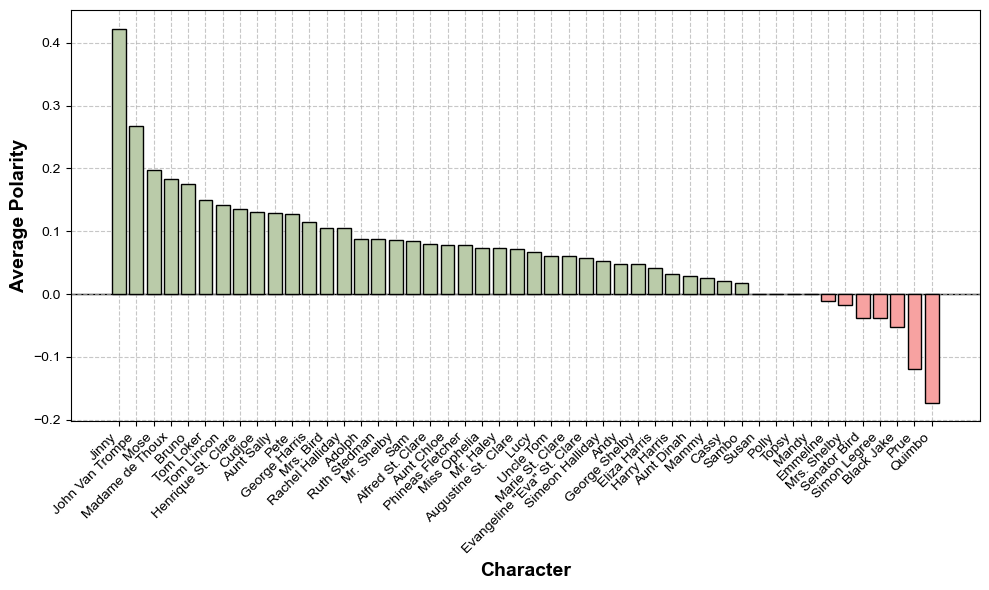

In [13]:
# Separate the keys and values for plotting
characters = [x[0] for x in sorted_chars]
avg_polarities = [x[1]['avg_polarity'] for x in sorted_chars]

plt.figure(figsize=(10, 6))
bars = plt.bar(characters, avg_polarities, color='skyblue', edgecolor='black', linewidth=1, zorder=10)

# Optionally, color negative vs positive differently:
for bar, val in zip(bars, avg_polarities):
    if val < 0:
        bar.set_color('#F7A2A1')
        bar.set_edgecolor('black')
    else:
        bar.set_color('#BACBA9')
        bar.set_edgecolor('black')

# Draw line at 0
plt.axhline(y=0, color='black', linewidth=1, linestyle='-', zorder=0)

# Rotate x-axis labels if there are many characters
plt.xticks(rotation=45, ha='right')

plt.xlabel("Character", fontsize=14, fontweight='bold')
plt.ylabel("Average Polarity", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7, zorder=0)
plt.tight_layout()

# Save to file
plt.savefig('results/sentiment_plot.png', dpi=600, bbox_inches='tight')
plt.show()

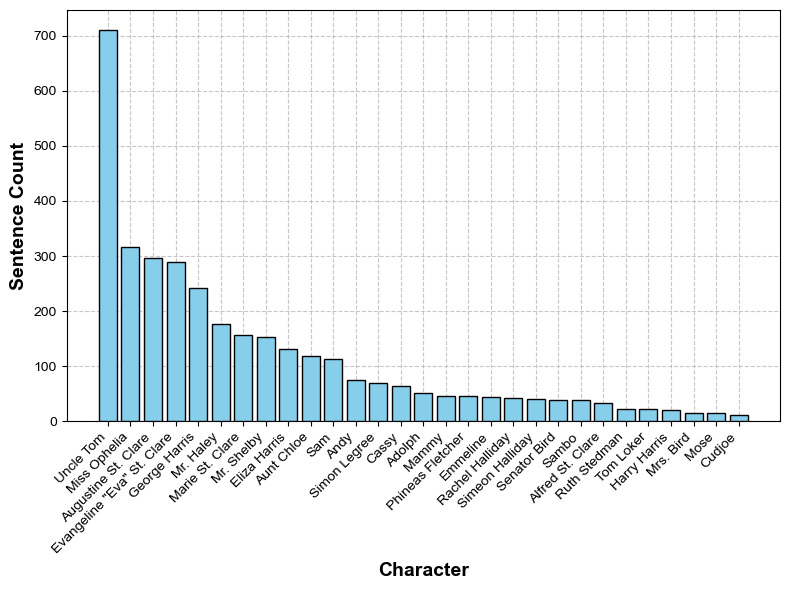

In [14]:
# Sort by num_references descending
sorted_chars = sorted(character_sentiments.items(), 
                        key=lambda x: x[1]['num_references'], 
                        reverse=True)

top_n = 30
top_chars = sorted_chars[:top_n]
top_chars = [x for x in top_chars if x[0] != "Other"]
names = [x[0] for x in top_chars]
counts = [x[1]['num_references'] for x in top_chars]

plt.figure(figsize=(8, 6))
plt.bar(names, counts, color='skyblue', edgecolor='black', linewidth=1, zorder=10)
plt.xticks(rotation=45, ha='right')
# plt.title(f"Top {top_n} Characters by Number of References")
plt.xlabel("Character", fontsize=14, fontweight='bold')
plt.ylabel("Sentence Count", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7, zorder=0)
plt.tight_layout()

# Save figure
plt.savefig('results/character_sentence_count.png', dpi=600, bbox_inches='tight')
plt.show()

In [15]:
def plot_sentiment_distribution(character_sentiments, character_name):
    """
    Plot a bar chart for negative/neutral/positive distribution of a given character.
    """
    if character_name not in character_sentiments:
        print(f"Character '{character_name}' not found in sentiments data.")
        return
    
    dist = character_sentiments[character_name]['distribution']
    labels = list(dist.keys())   # ['negative', 'neutral', 'positive']
    values = [dist[k] for k in labels]
    labels = [label.capitalize() for label in labels]
    
    plt.figure(figsize=(5, 4))
    plt.bar(labels, values, color=['#F7A2A1', 'gray', '#BACBA9'], edgecolor='black', linewidth=1, zorder=10)
    plt.title(f"{character_name}", fontsize = 14)
    plt.xlabel("Sentiment", fontsize=14, fontweight='bold')
    plt.ylabel("Count of Sentences", fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7, zorder=0)

    plt.savefig(f'results/sentiment_distribution/{character_name}.png', dpi=600, bbox_inches='tight')
    plt.close()

In [16]:
for character_name in characters_to_include:
    plot_sentiment_distribution(character_sentiments, character_name)

In [17]:
def build_character_cooccurrence_network(doc):
    """
    Build a co-occurrence network of characters.
    For each sentence, if multiple characters appear, increment an edge weight between them.
    Returns a dict of edge counts: { (charA, charB): count, ... }.
    """
    cooccurrence_counts = Counter()
    num_sents = len(list(doc.sents))
    
    for sent in tqdm(doc.sents, total=num_sents, desc="Building character co-occurrence network"):
        # Find person entities in the sentence
        person_entities = [harmonize_name(ent.text, verbose=False) 
                           for ent in sent.ents 
                           if ent.label_ == "PERSON"]
        
        # Get unique characters in this sentence (avoid double-counting if name repeated)
        unique_chars = set(person_entities)
        unique_chars.discard("Other")
        
        # If 2 or more chars in sentence, update pairwise co-occurrence
        if len(unique_chars) > 1:
            unique_chars_list = sorted(list(unique_chars))
            for i in range(len(unique_chars_list)):
                for j in range(i+1, len(unique_chars_list)):
                    charA = unique_chars_list[i]
                    charB = unique_chars_list[j]
                    pair = tuple(sorted([charA, charB]))
                    cooccurrence_counts[pair] += 1
    
    return cooccurrence_counts

In [18]:
cooccurrence_counts = build_character_cooccurrence_network(doc)
min_edge_weight = 2

G = nx.Graph()

# Get unique characters from cooccurrence_counts
unique_characters = list(set([char for pair in cooccurrence_counts.keys() for char in pair]))
unique_characters.sort()

# Empty interaction matrix d
int_matrix = np.zeros((len(unique_characters), len(unique_characters)))

# Add edges
for (charA, charB), count in tqdm(cooccurrence_counts.items(), total=len(cooccurrence_counts), desc="Building network"):
    if count >= min_edge_weight:
        G.add_edge(charA, charB, weight=count)

    # Add to interaction matrix
    int_matrix[unique_characters.index(charA), unique_characters.index(charB)] = count
    int_matrix[unique_characters.index(charB), unique_characters.index(charA)] = count

Building network: 100%|██████████| 116/116 [00:00<00:00, 470086.25it/s]


/Users/an583/miniforge3/envs/neuroKG/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/an583/miniforge3/envs/neuroKG/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


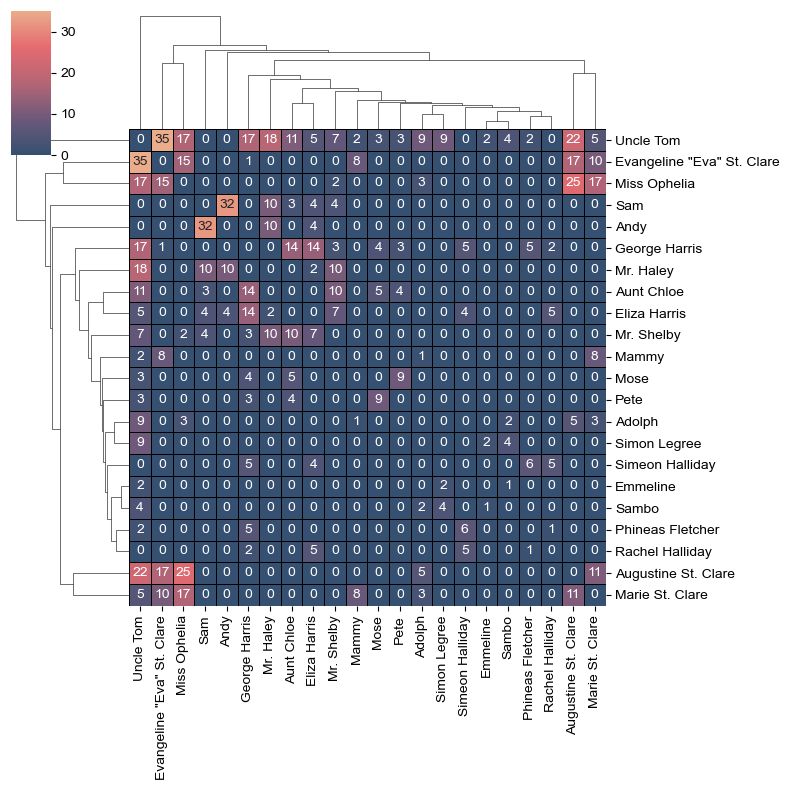

In [29]:
# Verify that the interaction matrix is symmetric
if not np.allclose(int_matrix, int_matrix.T):
    print("Warning: Interaction matrix is not symmetric.")

# Compute row sums
row_sums = np.sum(int_matrix, axis=1)

# Remove rows and columns with sum < threshold
threshold = 10
int_matrix_sparse = int_matrix[row_sums > threshold, :]
int_matrix_sparse = int_matrix_sparse[:, row_sums > threshold]

# Remove characters with sum < threshold
unique_characters_sparse = np.array(unique_characters)[row_sums > threshold]

# Get colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#355070", "#6d597a", "#b56576", "#e56b6f", "#eaac8b"], N=256)

# Create a clustermap
g = sns.clustermap(
    int_matrix_sparse,
    method='average',        # linkage method for clustering
    metric='euclidean',      # distance metric
    cmap=custom_cmap,        # custom colormap
    annot=True,              # annotate cells with the numeric values
    xticklabels=unique_characters_sparse,
    yticklabels=unique_characters_sparse,
    figsize=(8, 8),         # figure size
    linewidths=0.5,          # black border width
    linecolor='black'        # black border color
)

plt.savefig('results/character_cooccurrence_heatmap.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

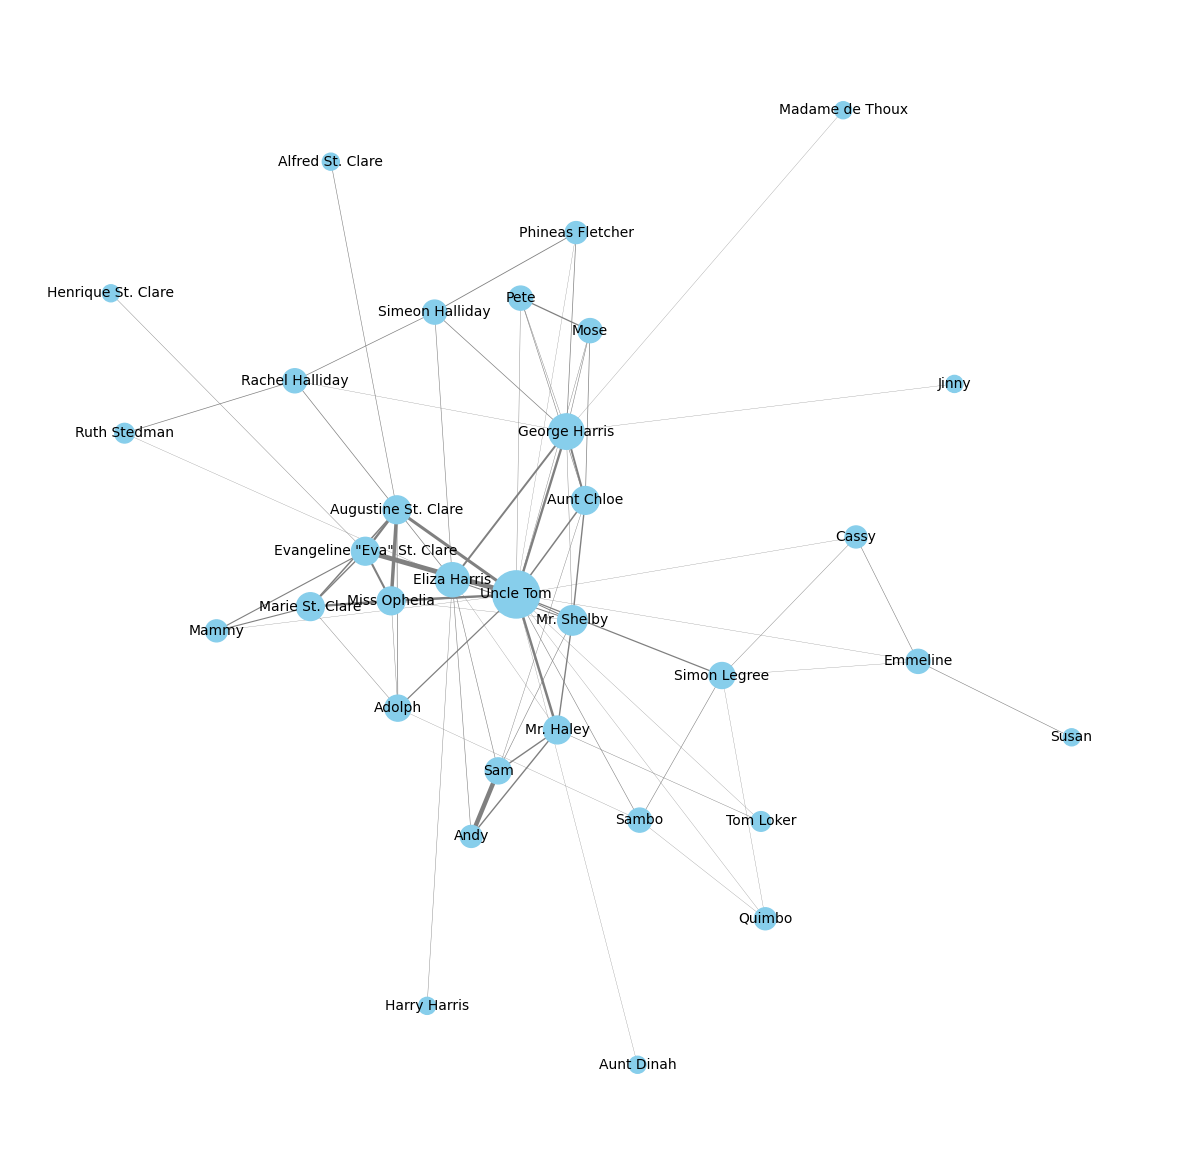

In [50]:
# Set seed
np.random.seed(19)

# Draw
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw nodes
node_sizes = [100 + 50 * G.degree(n) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')
# nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
# Draw edges
edge_weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w * 0.1 for w in edge_weights], edge_color='gray')
# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

# plt.title("Character Co-occurrence Network")
plt.axis('off')

# plt.savefig('results/character_cooccurrence_network.png', dpi=600, bbox_inches='tight')
plt.show()